# GP lab (OPTIONAL, 2 points)

This lab exercise allows you to implement your own Gaussian processes for regression. You can compare the results here with the results you got from the exercise with GPy.

**Author: Ruben Martinez-Cantin** (based on GPSS labs)

# How to submit the results

Make a copy of this file in your Drive. Then you can use textboxes to write directly your report. Download as .ipynb and submit that file in Moodle.

In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25, 10)
plt.rcParams["font.size"] = 16

# Function for plotting/shading.
def GaussPDFscaled(y, m, s):
  return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)

In [ ]:
# Optimization function. Used for the hyperparameter tuning/learning
from scipy.optimize import dual_annealing

# Cholesky decomposition functions
from scipy.linalg import cho_solve, cho_factor

We are going to use the [same data](https://drive.google.com/file/d/1wGlqnkXU-Fv6Tu8k0x3a5BR6CieLm_06/view?usp=sharing) used in the regression examples from the course slides. Of course, you can, and you should, try with a different dataset, like the [weight dataset](https://drive.google.com/file/d/1YYyQG-xuS1OV5Ww1ytZLzhe3YdvE_NKG/view?usp=sharing) from [Philipp Hennig](https://uni-tuebingen.de/en/fakultaeten/mathematisch-naturwissenschaftliche-fakultaet/fachbereiche/informatik/lehrstuehle/methoden-des-maschinellen-lernens/personen/philipp-hennig/)

Note: if you use your own data set, use only one data dimension. GPs are able to perform multidimensional regression, but the code is slightly longer and more complicated. Also, the implementation that we are using is not robust to outliers.

In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving data_gp.npz to data_gp.npz


In [ ]:
# Load the data from the file
if 'data_gp.npz' in uploaded.keys():
  data = np.load('data_gp.npz')
  dataX = data['X']
  dataY = data['Y']
  sigma_noise = data['sigma']
elif 'weightdata_clean.mat' in uploaded.keys():
  # You can also use the weight dataset.
  # Note that for the weight dataset we select a random subset of just 100 points
  # to avoid large computation times.
  data=scipy.io.loadmat('weightdata_clean.mat')

  # random selection of 100 points
  id = np.array(range(len(data['dat'])))
  np.random.shuffle(id)
  id = id[:100]

  dataX = np.atleast_2d(data['dat'][id,0]).T
  dataY = np.atleast_2d(data['dat'][id,1]).T
  sigma_noise = 1


# We normalize the data.
# This is better to adjust the lengthscale and also for plotting
dataX -= dataX.min()
dataX /= dataX.max() - dataX.min()

# GP implementation
This is the code to implement a GP class. There are already implemented several methods for initialization, plotting, tunning the hyperarameters, etc.

You also have already implemented the Square Exponential kernel
$$
k(x_1,x_2) = \sigma_s^2 \cdot \exp{\left(\frac{|x_1-x_2|^2}{2l^2}\right)}
$$

## Prediction
Your job is to compute the prediciton function to return both the predicted mean $\widehat{f_*}$ and variance $\sigma^2_{f_*}$ for a query point $\bf x_*$.

Remember that:
$$
\begin{align}
\widehat{f_*} &= k(x_*,X) (k(X,X) + \sigma^2_nI)^{-1} \mathbf{y}\\
\sigma^2_{f_*} &= k(x_*,x_*) - k(x_*,X) (k(X,X) + \sigma^2_nI)^{-1} k(X, x_*)\\
\end{align}
$$
where the kernel matrix is:
$$
k(X,X) = \left(\begin{array}{ccc}
k(x_1,x_1) & \ldots & k(x_1,x_n) \\
k(x_2,x_1) & \ldots & k(x_2,x_n) \\
\vdots & \ddots & \vdots\\
k(x_n,x_1) & \ldots & k(x_n,x_n)\\
\end{array}\right)
$$
and the correlation vector is:
$$
k(x_*,X) = k(X,x_*)^T = \left(\begin{array}{c}
k(x_1,x_*)\\
k(x_2,x_*)\\
\vdots\\
k(x_n,x_*)\\
\end{array}\right)
$$

For the prediction, remember than in numpy, the matrix multiplication is `A @ B`, the transpose `A.T` and the inverse is `numpy.linalg.inv(A)`.

If you want to try the more efficient method from the slides, you can use the Cholesky decomposition with `L = cho_factor(K)` and the solve command, with is represented in the slides as $L \backslash y$ can be computed `cho_solve(L,y)`. Both functions are loaded from `scipy.linalg`.

## Log-likelihood
If you want to learn the hyperparameters, you also need to implement the log-likelihood method. Again, you can use the straightforward method and implement this equation:

$$
\log p(y|X,\theta) = -\frac{1}{2}\mathbf{y}^T (k(X,X) + \sigma^2_nI)^{-1} \mathbf{y} -\frac{1}{2}\log|k(X,X) + \sigma^2_nI| -  \frac{n}{2}\log 2\pi
$$

where $|k(X,X)|$ is the determinant of the covariance matrix. Or you can implement the version from the slides using the Cholesky decomposition.

Notes:
- The method requires the **negative** log-likelihood because the algorithm that we use for optimization finds the minimum, instead of the maximum.
- You need to recompute the whole covariance matrix every time you compute the log-likelihood because the kernel hyperarameters have changed.
- Usually, it is better to use a gradient based optimization for maximum likelihood, but we use a gradient-free version so you don't need to implement it. :-)



In [ ]:
class GP:
  def __init__(self, X, Y, sigma_noise):
    # Store the dataset
    self.X = X
    self.Y = Y

    # Observation noise / likelihood
    self.sigma_n = sigma_noise

    # Kernel hyperparameters (default values)
    self.ell = 1.0
    self.sigma_s = 1.0


  def kernel(self, x1, x2):
    # Kernel function (Square exponential)
    # Note that x1 and x2 might be vectors of points (vectorized calls)
    ell = self.ell
    sigma = self.sigma_s
    return sigma * np.exp(-0.5*(x1-x2)**2/ell)

  def compute_kernel_matrix(self):
    # Computes the kernel matrix for the dataset points
    X = self.X
    return self.kernel(X, X.T)

  def compute_cross_correlation(self, x):
    # Computes the correlation between the dataset points and a new point x
    X = self.X
    return self.kernel(x, X.T)

  def predict(self, x):

    ###################################################################
    # YOUR CODE HERE.
    # COMPUTE THE VALUES OF MEAN f* AND COV sigma2_f* EVALUATED AT x
    ###################################################################

    # Compute the kernel between x and dataset points
    k_x_X = self.compute_cross_correlation(x)

    # Compute the kernel matrix for dataset points
    K = self.compute_kernel_matrix()

    # Add observation noise to the diagonal of the kernel matrix
    K += self.sigma_n**2 * np.eye(len(self.X))
    print("Shape of k_x_X:", k_x_X.shape)
    print("Shape of K:", K.shape)

    # Compute the mean prediction
    mean = np.dot(np.dot(k_x_X, np.linalg.inv(K)), self.Y.flatten()[:, np.newaxis]).item()


    # Compute the covariance prediction
    k_xx = self.kernel(x, x)
    cov = k_xx - np.dot(k_x_X, np.linalg.solve(K, k_x_X.T))



    return mean, cov



  def neg_log_likelihood(self, hyperparams):
    # Computes the negative log-likelihood for hyperarameter tuning

    # We assign the hyperparameters that we are evaluating as the GP
    # hyperparameters. If we call the kernel now, it will be with the new
    # hyperparameters.

    ###################################################################
    # YOUR CODE HERE.
    # COMPUTE THE VALUE OF THE NEGATIVE LOG-LIKELIHOOD.
    # Note that the new leghtscale and sigma are already asigned.
    ###################################################################
    # Assign the hyperparameters
    self.ell = np.exp(hyperparams[0])
    self.sigma_s = np.exp(hyperparams[1])

    # Compute the kernel matrix for dataset points
    K = self.compute_kernel_matrix()

    # Compute the negative log-likelihood
    n = len(self.X)
    y = np.array(self.Y).reshape((n, 1))
    term1 = 0.5 * np.dot(y.T, np.linalg.solve(K + self.sigma_n**2 * np.eye(n), y))[0, 0]
    term2 = 0.5 * np.log(np.linalg.det(K + self.sigma_n**2 * np.eye(n)))
    term3 = 0.5 * n * np.log(2 * np.pi)

    negative_log_likelihood = term1 + term2 + term3

    return negative_log_likelihood



  def tune_hyperparameters(self):
    # Method to optimize the hyperparameters. It will call neg_log_likelihood
    # with several versions of the hyperparameters and return the values with the
    # minimum neg_log_likelihood, that is, the maximum log_likelihood.

    # Trivia: the hyperparameters can be very large or very small.
    # It is very tricky to do so searching uniformly. Instead, we optimize the
    # log(hyperparameter). Intuitively, we are optimizing the order of magnitude.
    # This way, we have more resolution with smaller values, which is what we want.
    bounds = [(-6, 6), (-6, 6)]
    ret = dual_annealing(self.neg_log_likelihood, bounds)
    if ret.success:
      print("Updating hyperparameters. New values: ", np.exp(ret.x))
      self.ell = np.exp(ret.x[0])
      self.sigma_s = np.exp(ret.x[1])

    return ret.success

  def plotGP(self):
    # Plotting function. We just take a grid of 100 points in the whole interval
    # and we compute the predicion at those points.
    fig, ax = plt.subplots(1,1)
    xin = np.linspace(-0.2,1.2,100)
    output = [self.predict(x) for x in xin]
    mx, stdp = [np.array([mean for mean, cov in output]).flatten(),
                np.array([np.sqrt(cov) for mean, cov in output]).flatten()]

    yy = np.linspace(dataY.min()-3, dataY.max()+3, 200).reshape([200, 1])
    shadow = GaussPDFscaled(yy, mx, stdp)
    ax.imshow(
        shadow, extent=[-0.2,1.2, dataY.min()-3, dataY.max()+3], aspect="auto", origin="lower", cmap="Blues", alpha=0.4
    )

    ax.plot(xin , mx, "-", color='b')
    ax.plot(xin , mx + 2 * stdp, "-", color='steelblue')
    ax.plot(xin , mx - 2 * stdp, "-", color='steelblue')
    ax.plot(self.X, self.Y, 'ko')

The predict method, predicts the mean and covariance of the output at a given input point x based on the Gaussian Process model parameters.It uses a few small supports functions that we have created in order to compute the cross relation and the kernel matrix. Meanwhile, the neg_log_likelihood method is responsible for computing the negative log-likelihood of the Gaussian Process model.

Here, you have a small code snippet to test your GP with different leghtscales and with tuned hyperparameters.

Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k_x_X: (1, 20)
Shape of K: (20, 20)
Shape of k

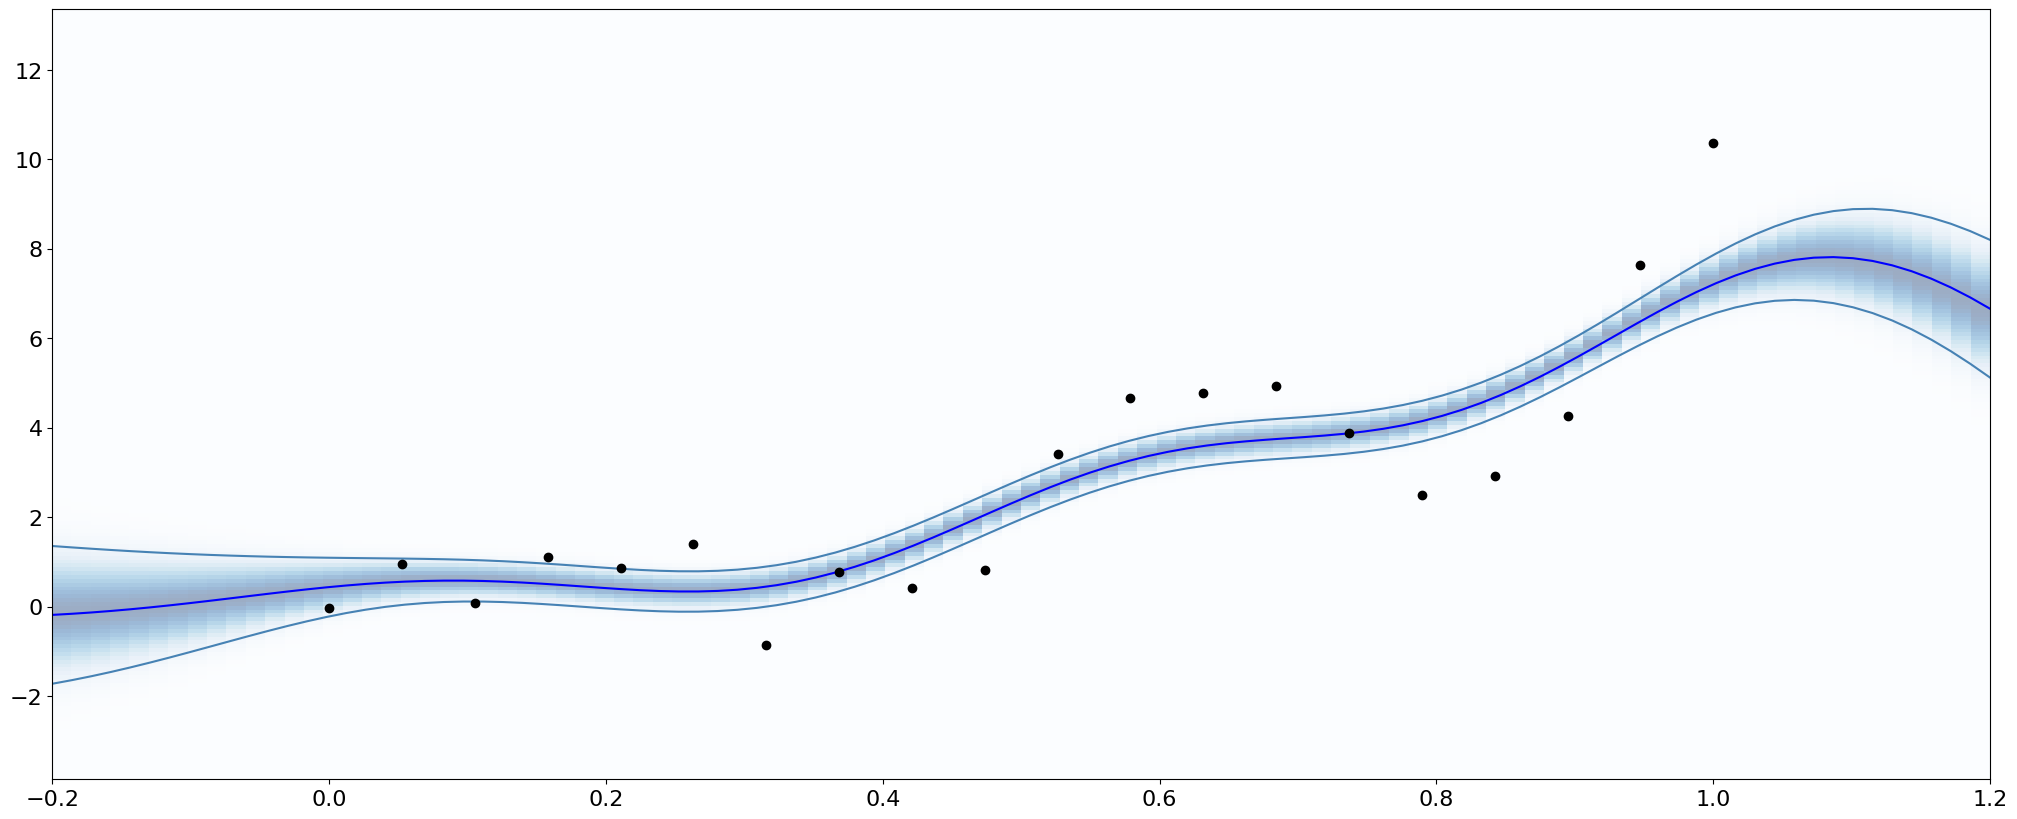

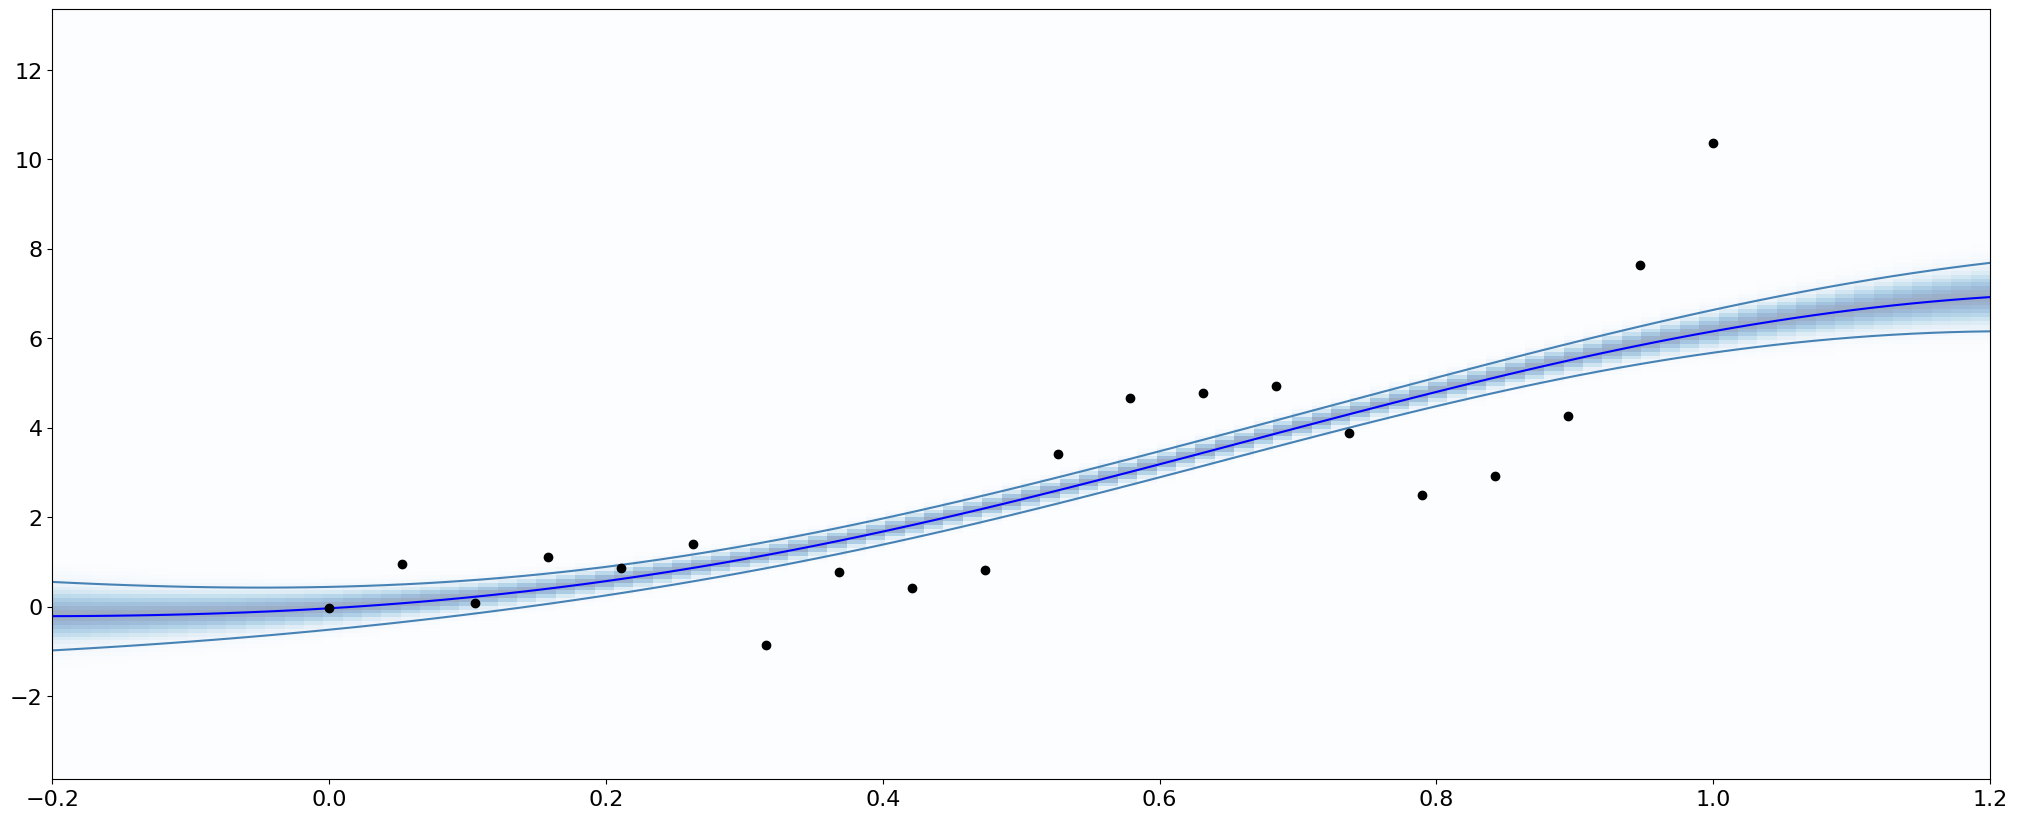

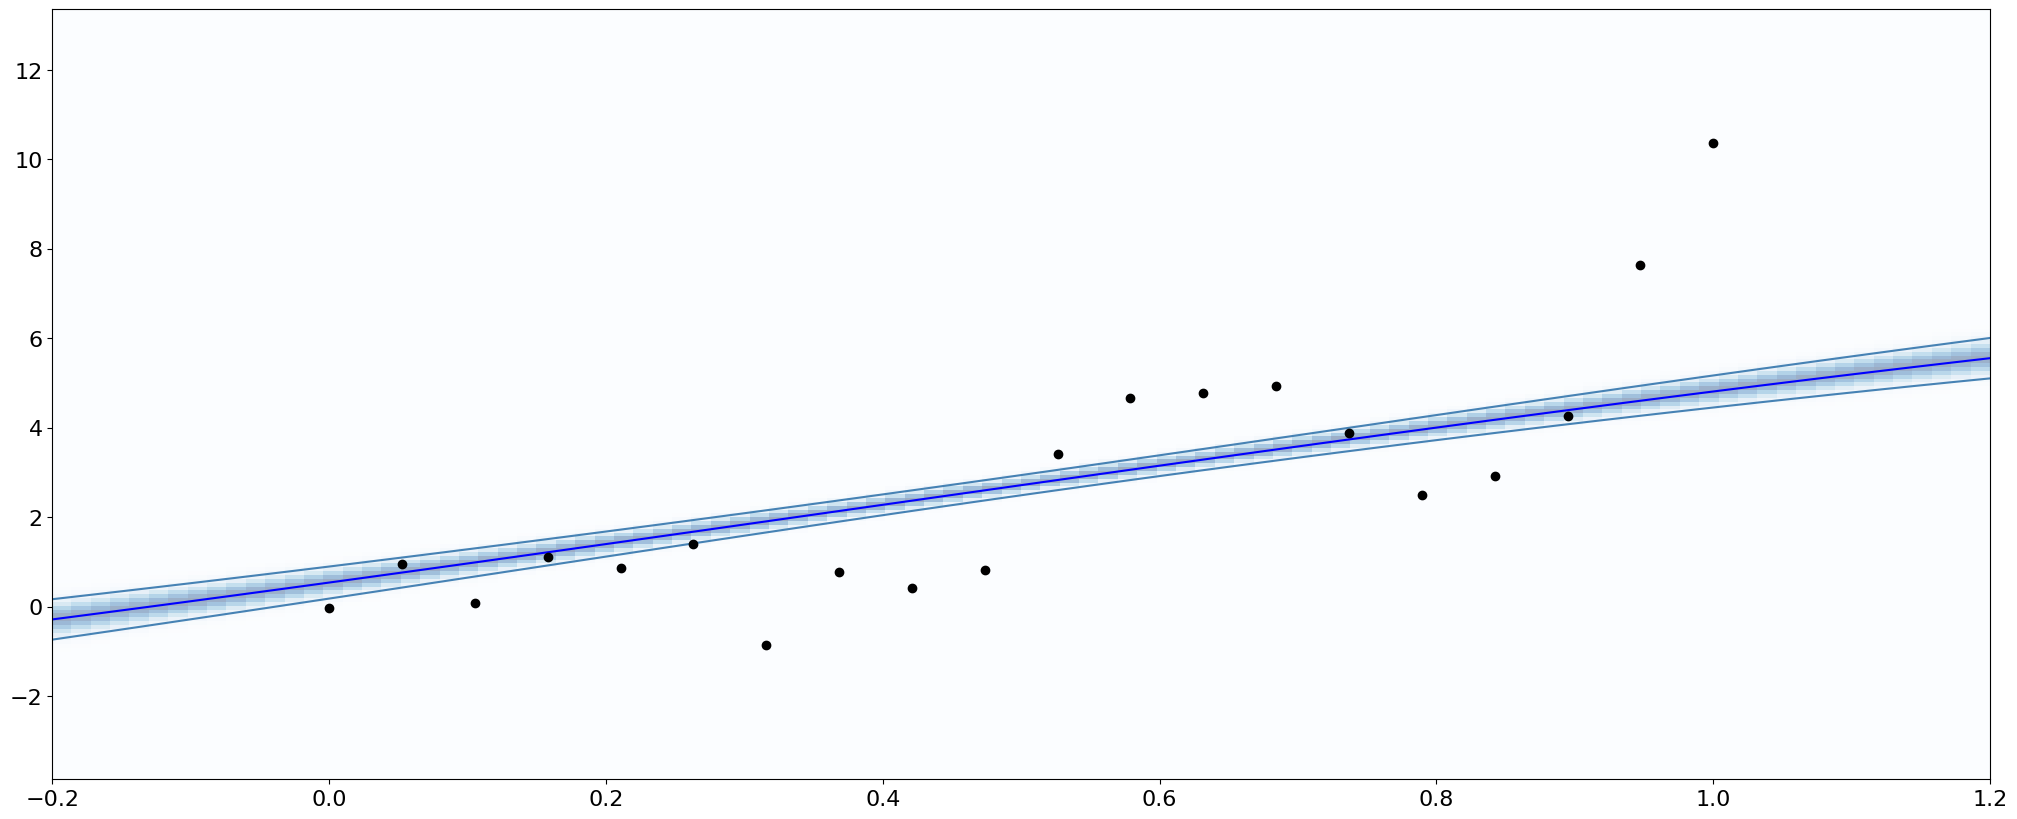

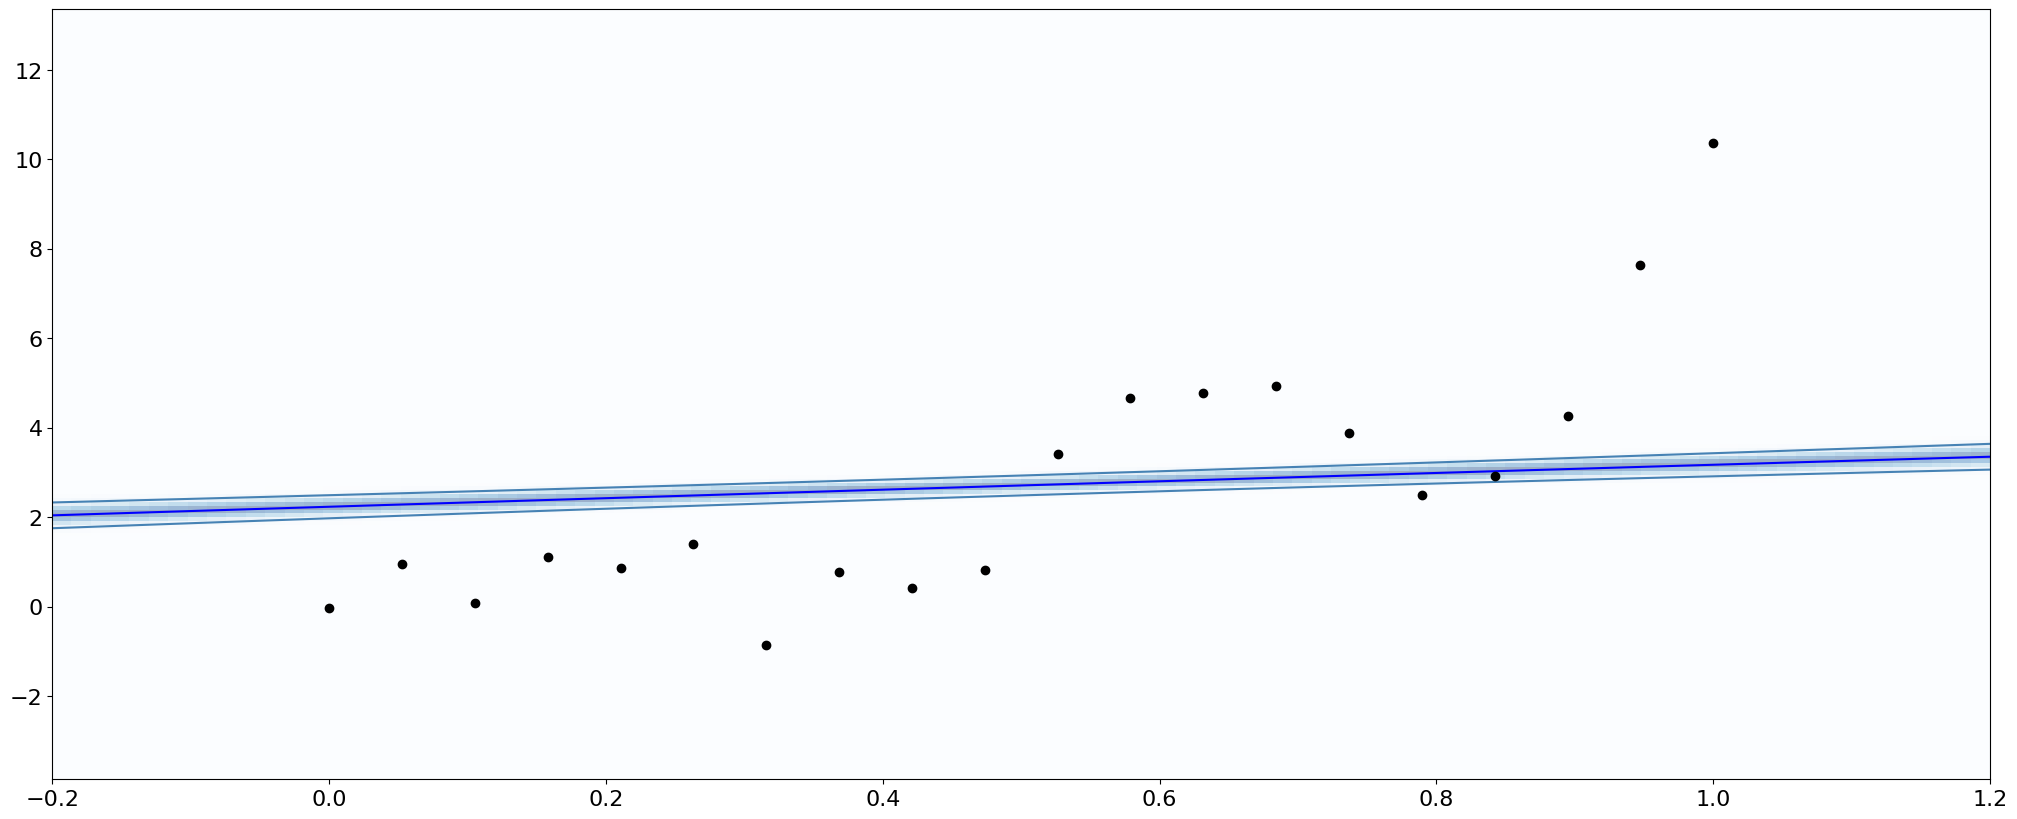

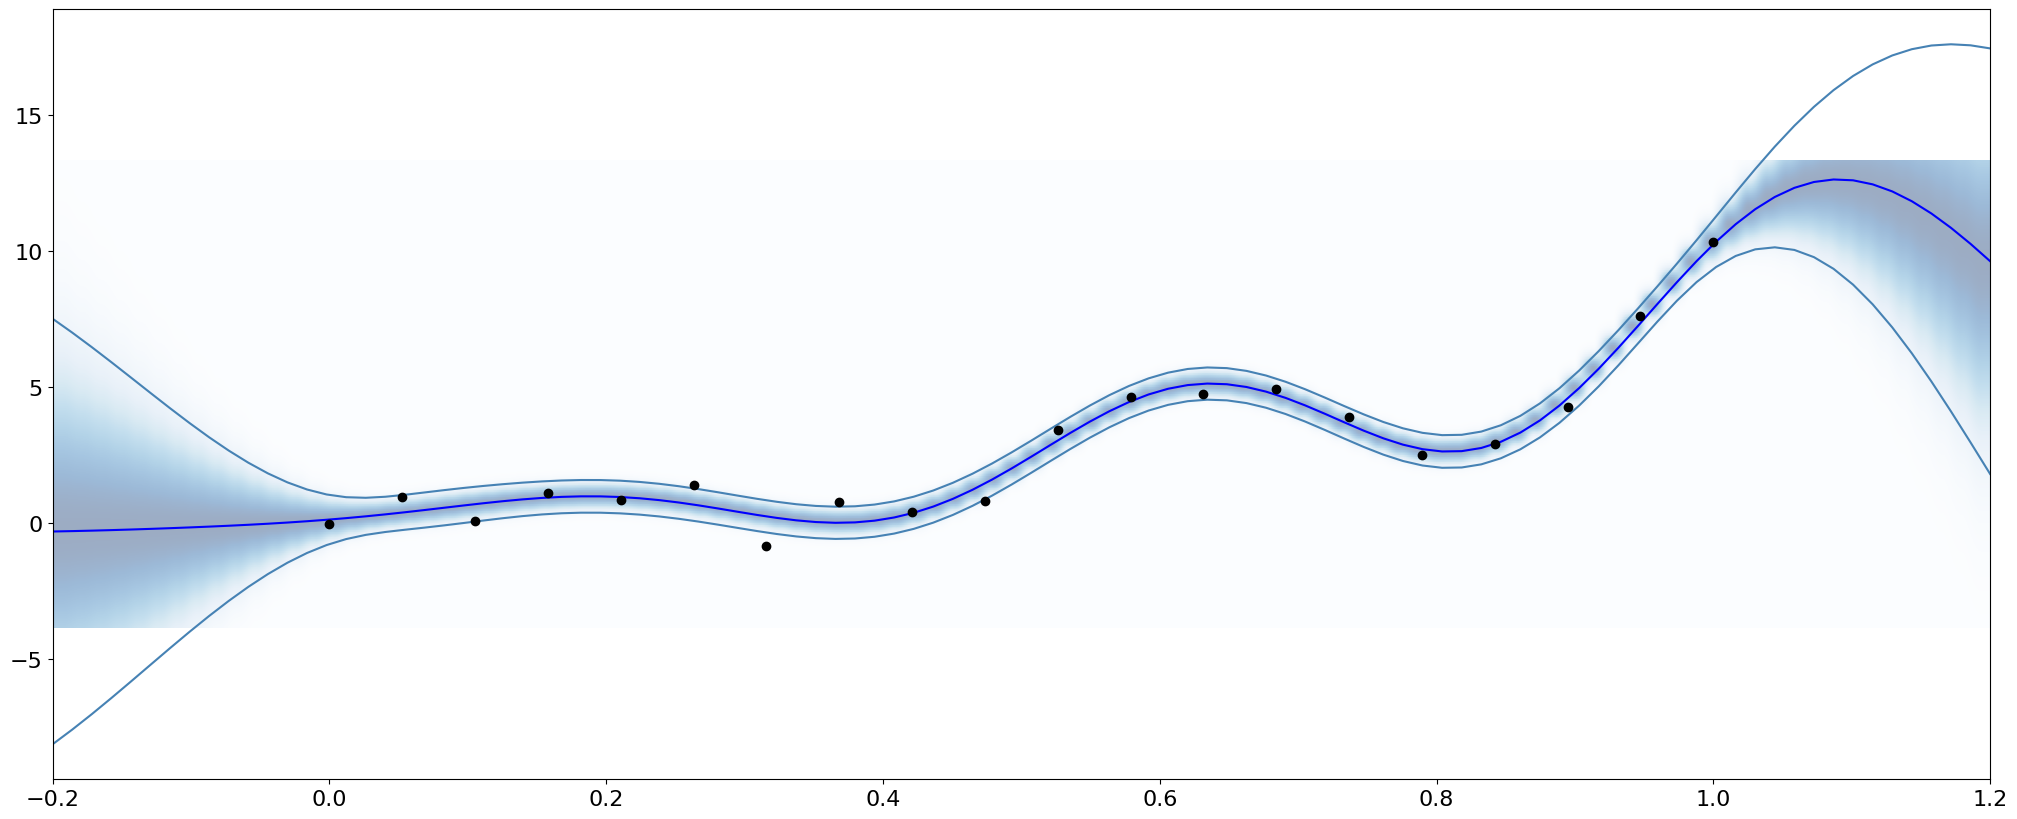

In [ ]:
my_gp = GP(dataX, dataY, sigma_noise)
for i in [0.05, 0.5, 5, 50]:
  my_gp.ell = i
  my_gp.plotGP()


my_gp.tune_hyperparameters()
my_gp.plotGP()
plt.show()

# Your tasks

**Choose one between 1. and 2.** There is no extra points for implementing both versions!
1. (1 point) Implement the prediction and log-likelihood methods using the standard equations (with the inverse).
2. (1.5 points) If you implement the prediction with the Cholesky decompose using the equations / algorithms from the slides.
3. (0.5 points) Implement a different kernel for comparison. For example: the Matern 3/2 kernel. The code for computing the covariance matrix and correlation vector assumes that the kernel can be vectorized, which can be tricky. If your kernel does not work vectoriced, replace `compute_kernel_matrix` and `compute_cross_correlation` using loops.

$$
k_{Matern32}(x_1,x_2) = \sigma_s \left(1 + \frac{\sqrt{3}|x_1-x_2|}{l}\right) \cdot \exp\left(- \frac{\sqrt{3}|x_1-x_2|}{l}\right)
$$

In this case, $|x|$ is the absolute value.

**CONCLUSIONS FOR THE POINT 1:** At the bottom of the previous cell inputs are the graphs with the predictions. The last one is the one that better adapts in comparison with the others that have different lenghtscales. In general it can be seen that there are a considerable error in some of the graphics in the prediction, especially in the third graph.  